
# Training an FNO with incremental meta-learning
In this example, we demonstrate how to use the small Darcy-Flow 
example we ship with the package to demonstrate the Incremental FNO
meta-learning algorithm


In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop.training import AdamW
from neuralop.training.incremental import IncrementalFNOTrainer
from neuralop.data.transforms.data_processors import IncrementalDataProcessor
from neuralop import LpLoss, H1Loss

Loading the Darcy flow dataset



In [2]:
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
    n_train=100,
    batch_size=16,
    test_resolutions=[16, 32],
    n_tests=[100, 50],
    test_batch_sizes=[32, 32],
)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


C:\Users\Evave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\neuralop\data\datasets\pt_dataset.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub fo

Choose device



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Set up the incremental FNO model
We start with 2 modes in each dimension
We choose to update the modes by the incremental gradient explained algorithm



In [4]:
incremental = True
if incremental:
    starting_modes = (2, 2)
else:
    starting_modes = (16, 16)

set up model



In [5]:
model = FNO(
    max_n_modes=(16, 16),
    n_modes=starting_modes,
    hidden_channels=32,
    in_channels=1,
    out_channels=1,
)
model = model.to(device)
n_params = count_model_params(model)

Set up the optimizer and scheduler



In [6]:
optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)


# If one wants to use Incremental Resolution, one should use the IncrementalDataProcessor - When passed to the trainer, the trainer will automatically update the resolution
# Incremental_resolution : bool, default is False
#    if True, increase the resolution of the input incrementally
#    uses the incremental_res_gap parameter
#    uses the subsampling_rates parameter - a list of resolutions to use
#    uses the dataset_indices parameter - a list of indices of the dataset to slice to regularize the input resolution
#    uses the dataset_resolution parameter - the resolution of the input
#    uses the epoch_gap parameter - the number of epochs to wait before increasing the resolution
#    uses the verbose parameter - if True, print the resolution and the number of modes
data_transform = IncrementalDataProcessor(
    in_normalizer=None,
    out_normalizer=None,
    device=device,
    subsampling_rates=[2, 1],
    dataset_resolution=16,
    dataset_indices=[2, 3],
    epoch_gap=10,
    verbose=True,
)

data_transform = data_transform.to(device)

Original Incre Res: change index to 0
Original Incre Res: change sub to 2
Original Incre Res: change res to 8


Set up the losses



In [7]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
train_loss = h1loss
eval_losses = {"h1": h1loss, "l2": l2loss}
print("\n### N PARAMS ###\n", n_params)
print("\n### OPTIMIZER ###\n", optimizer)
print("\n### SCHEDULER ###\n", scheduler)
print("\n### LOSSES ###")
print("\n### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###")
print(f"\n * Train: {train_loss}")
print(f"\n * Test: {eval_losses}")
sys.stdout.flush()


### N PARAMS ###
 2110305

### OPTIMIZER ###
 AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 0.008
    lr: 0.008
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###

 * Train: <neuralop.losses.data_losses.H1Loss object at 0x000001DD851AF690>

 * Test: {'h1': <neuralop.losses.data_losses.H1Loss object at 0x000001DD851AF690>, 'l2': <neuralop.losses.data_losses.LpLoss object at 0x000001DD851BEE50>}


Set up the IncrementalTrainer
other options include setting incremental_loss_gap = True
If one wants to use incremental resolution set it to True
In this example we only update the modes and not the resolution
When using the incremental resolution one should keep in mind that the numnber of modes initially set should be strictly less than the resolution
Again these are the various paramaters for the various incremental settings
incremental_grad : bool, default is False
   if True, use the base incremental algorithm which is based on gradient variance
   uses the incremental_grad_eps parameter - set the threshold for gradient variance
   uses the incremental_buffer paramater - sets the number of buffer modes to calculate the gradient variance
   uses the incremental_max_iter parameter - sets the initial number of iterations
   uses the incremental_grad_max_iter parameter - sets the maximum number of iterations to accumulate the gradients
incremental_loss_gap : bool, default is False
   if True, use the incremental algorithm based on loss gap
   uses the incremental_loss_eps parameter



In [8]:
# Finally pass all of these to the Trainer
trainer = IncrementalFNOTrainer(
    model=model,
    n_epochs=20,
    data_processor=data_transform,
    device=device,
    verbose=True,
    incremental_loss_gap=False,
    incremental_grad=True,
    incremental_grad_eps=0.9999,
    incremental_loss_eps = 0.001,
    incremental_buffer=5,
    incremental_max_iter=1,
    incremental_grad_max_iter=2,
)

Train the model



In [9]:
trainer.train(
    train_loader,
    test_loaders,
    optimizer,
    scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,
)

Training on 100 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Raw outputs of shape torch.Size([16, 1, 8, 8])
[0] time=1.16, avg_loss=0.9405, train_err=13.4357
Eval: 16_h1=0.8910, 16_l2=0.5812, 32_h1=0.9272, 32_l2=0.5825
[1] time=0.12, avg_loss=0.8281, train_err=11.8304
Eval: 16_h1=0.8094, 16_l2=0.4774, 32_h1=0.9608, 32_l2=0.4972
[2] time=0.07, avg_loss=0.6755, train_err=9.6494
Eval: 16_h1=0.7676, 16_l2=0.4130, 32_h1=0.9381, 32_l2=0.4312
[3] time=0.07, avg_loss=0.6108, train_err=8.7255
Eval: 16_h1=0.8143, 16_l2=0.4600, 32_h1=1.1269, 32_l2=0.5006
[4] time=0.06, avg_loss=0.5708, train_err=8.1545
Eval: 16_h1=0.8113, 16_l2=0.4792, 32_h1=1.1304, 32_l2=0.5214
[5] time=0.07, avg_loss=0.5317, train_err=7.5956
Eval: 16_h1=0.7682, 16_l2=0.4352, 32_h1=1.0682, 32_l2=0.4729
[6] time=0.07, avg_loss=0.5032, train_err=7.1888
Eval: 16_h1=0.6855, 16_l2=0.3459, 32_h1=1.0006, 32_l2=0.3821
[7] time=0.06, avg_loss=0.4430, train_err=6.3290
Eval: 16_h1=0.6172, 16_l2=0.3445, 32_h1=0.8399,

{'train_err': 3.8232131685529436,
 'avg_loss': 0.26762492179870606,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.07271450001280755,
 '16_h1': tensor(0.3170, device='cuda:0'),
 '16_l2': tensor(0.2076, device='cuda:0'),
 '32_h1': tensor(0.4604, device='cuda:0'),
 '32_l2': tensor(0.2245, device='cuda:0')}

Plot the prediction, and compare with the ground-truth
Note that we trained on a very small resolution for
a very small number of epochs
In practice, we would train at larger resolution, on many more samples.

However, for practicity, we created a minimal example that
i) fits in just a few Mb of memory
ii) can be trained quickly on CPU

In practice we would train a Neural Operator on one or multiple GPUs



C:\Users\Evave\AppData\Local\Temp\ipykernel_19224\2098455258.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


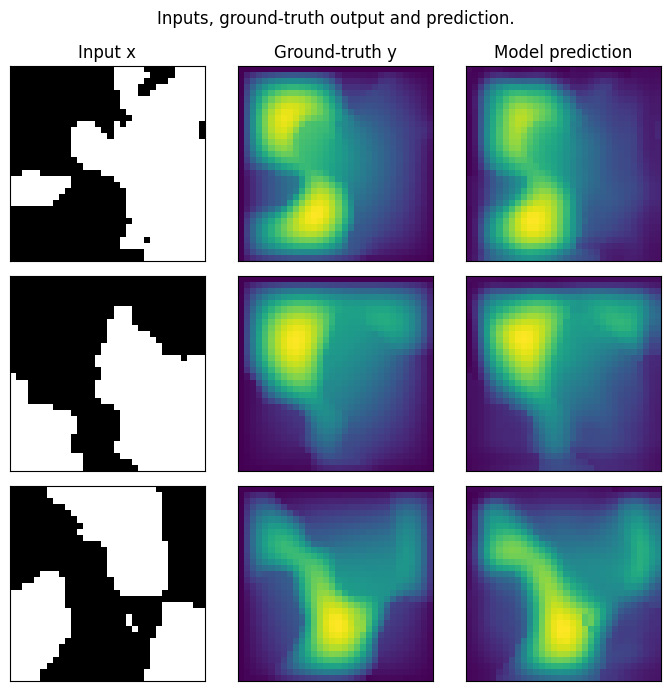

In [10]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data["x"].to(device)
    # Ground-truth
    y = data["y"].to(device)
    # Model prediction
    out = model(x.unsqueeze(0))
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    x = x.cpu().squeeze().detach().numpy()
    y = y.cpu().squeeze().detach().numpy()
    ax.imshow(x, cmap="gray")
    if index == 0:
        ax.set_title("Input x")
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index * 3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title("Ground-truth y")
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index * 3 + 3)
    ax.imshow(out.cpu().squeeze().detach().numpy())
    if index == 0:
        ax.set_title("Model prediction")
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle("Inputs, ground-truth output and prediction.", y=0.98)
plt.tight_layout()
fig.show()